In [10]:
# Heavy Rainfall Prediction Analysis
# ========================================

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import requests
from io import BytesIO
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
%matplotlib inline

Dataset basic information:
Shape: (87672, 28)
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Time range: 2015-01-01 00:53:00 to 2024-12-31 23:53:00

Data types:
STATION                             float64
REPORT_TYPE                          object
HourlyAltimeterSetting              float64
HourlyDewPointTemperature           float64
HourlyDryBulbTemperature            float64
HourlyPrecipitation                 float64
HourlyPresentWeatherType             object
HourlyPressureChange                float64
HourlyPressureTendency              float64
HourlyRelativeHumidity              float64
HourlySeaLevelPressure              float64
HourlySkyConditions                  object
HourlyStationPressure               float64
HourlyVisibility                    float64
HourlyWetBulbTemperature            float64
HourlyWindDirection                  object
HourlyWindGustSpeed                 float64
HourlyWindSpeed                     float64
WeatherType_Missing         

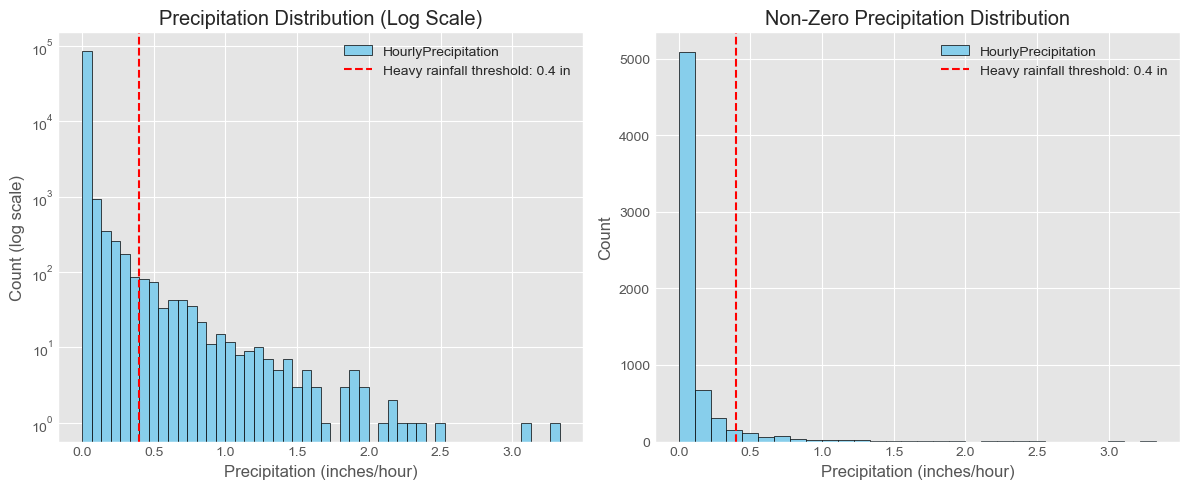


Heavy rainfall statistics:
Total hours: 87672
Hours with heavy rainfall: 430
Percentage of heavy rainfall: 0.49%

Top 10 heaviest rainfall events (potential cloudbursts):
                     HourlyPrecipitation  HourlyDryBulbTemperature  \
date_index                                                           
2020-05-26 17:53:00                 3.33                      72.0   
2020-05-26 16:53:00                 3.09                      72.0   
2017-07-12 19:53:00                 2.49                      75.0   
2017-06-02 07:53:00                 2.35                      75.0   
2023-06-19 14:53:00                 2.32                      75.0   
2022-06-01 17:53:00                 2.23                      73.0   
2016-08-02 18:53:00                 2.19                      73.0   
2017-07-21 11:53:00                 2.17                      74.5   
2018-07-28 13:53:00                 2.12                      77.0   
2021-09-23 14:53:00                 1.99                  

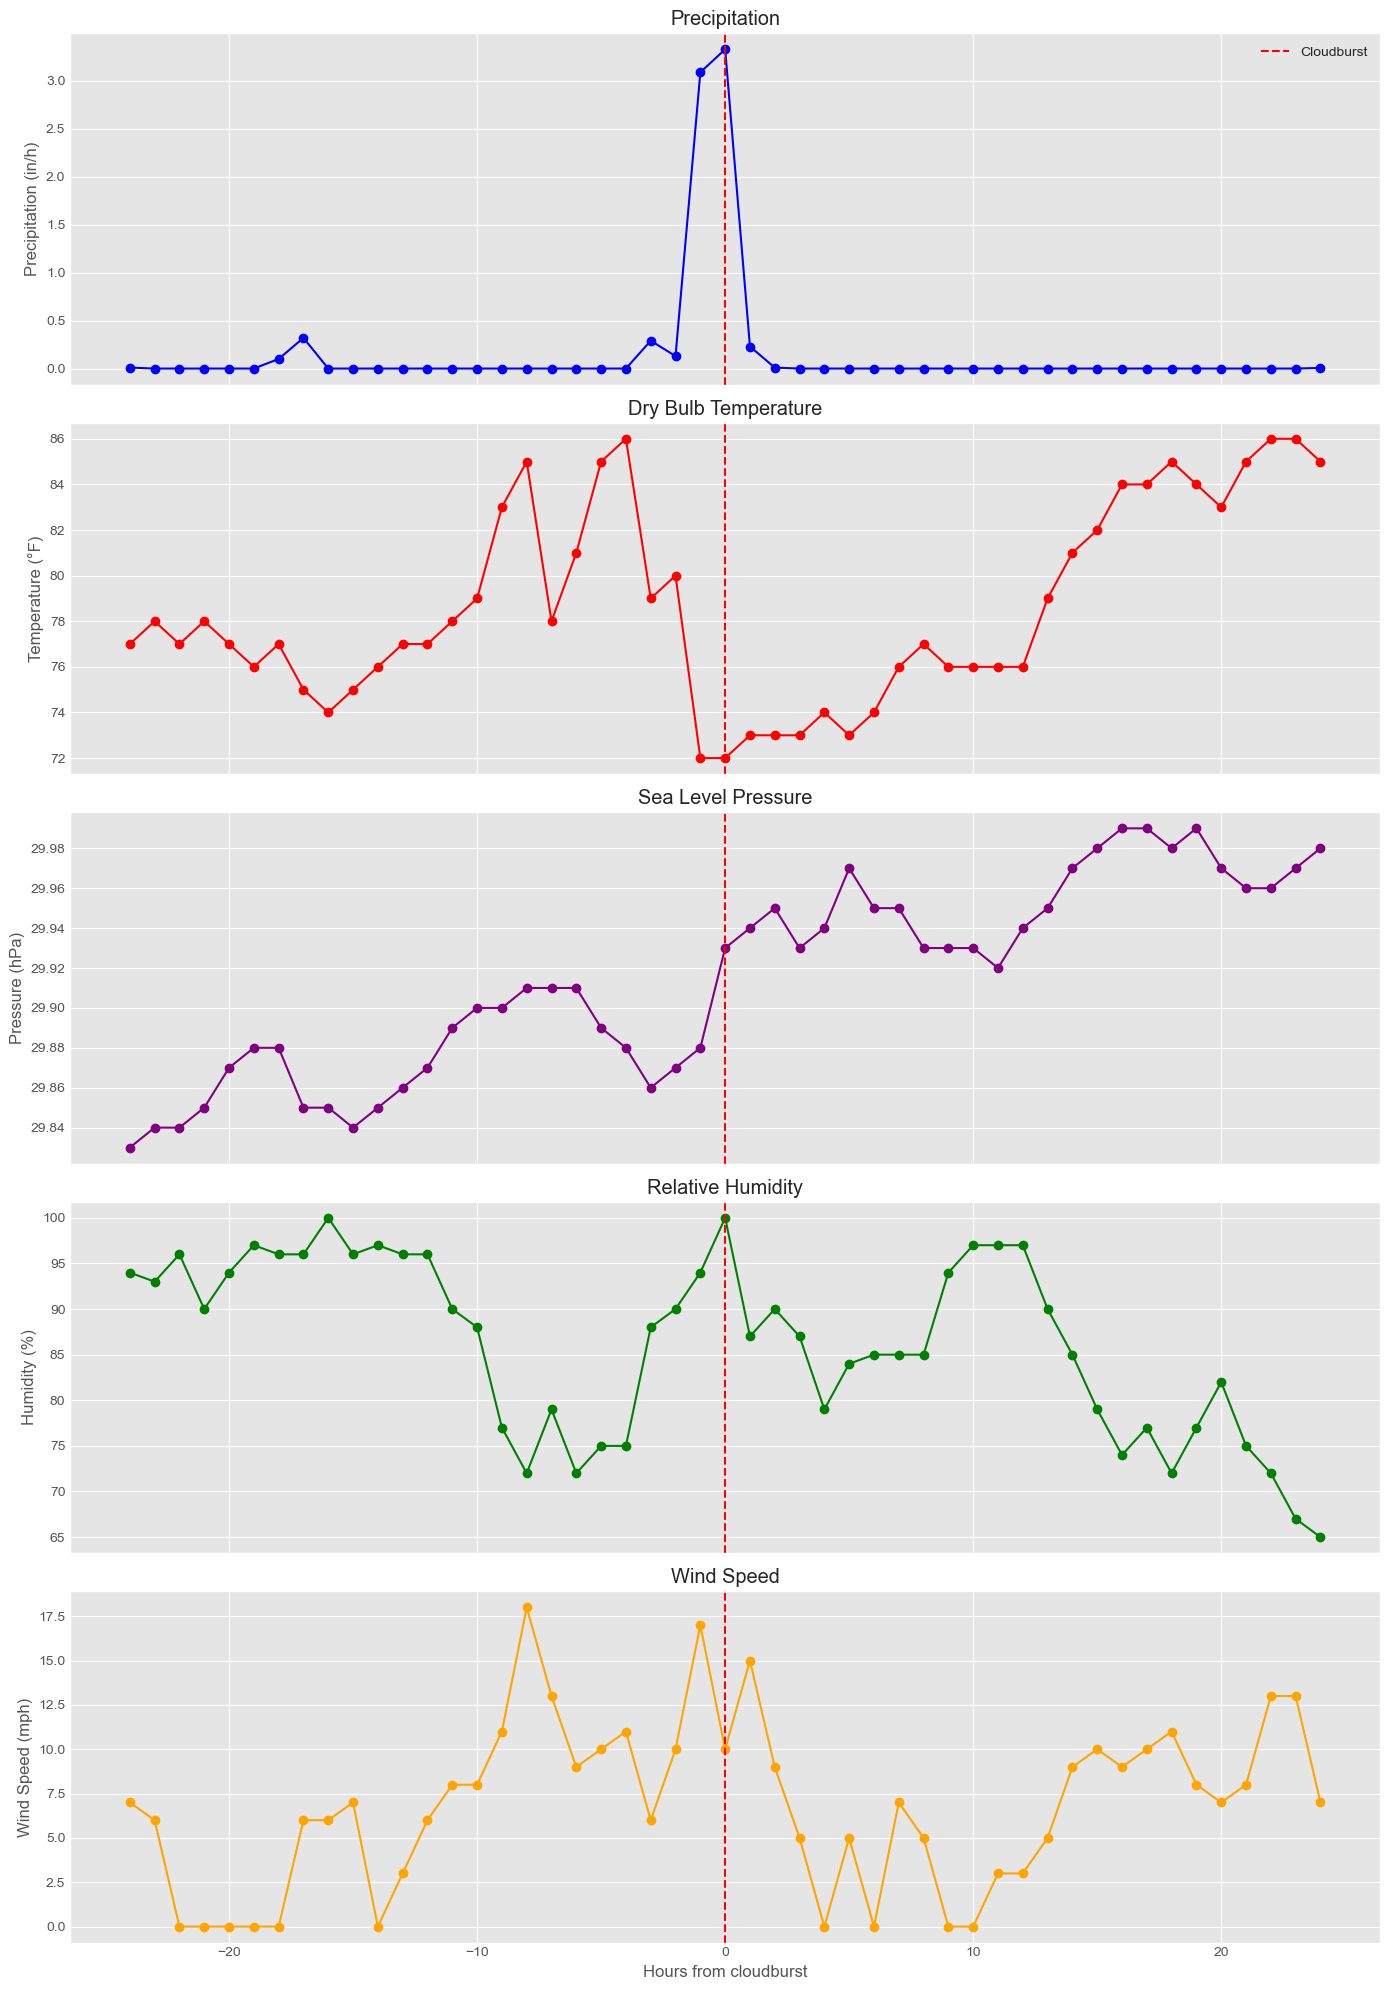


Implementing new features based on cloudburst mechanisms...

Summary of new features:
HoursSinceLastRain: count    87672.000000
mean        63.879528
std         81.455419
min          0.000000
25%          9.000000
50%         34.000000
75%         87.000000
max        562.000000
Name: HoursSinceLastRain, dtype: float64
TempHumidityIndex: count    87650.000000
mean       155.168071
std         12.246586
min         92.854000
25%        149.189000
50%        158.238000
75%        164.129000
max        181.209000
Name: TempHumidityIndex, dtype: float64
TempDewPointSpread: count    87650.000000
mean        10.143584
std          5.700836
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         46.000000
Name: TempDewPointSpread, dtype: float64
PressureChange3h: count    87632.000000
mean        -0.000007
std          0.035358
min         -1.218400
25%         -0.030000
50%          0.000000
75%          0.030000
max          1.225600
Name: Pres

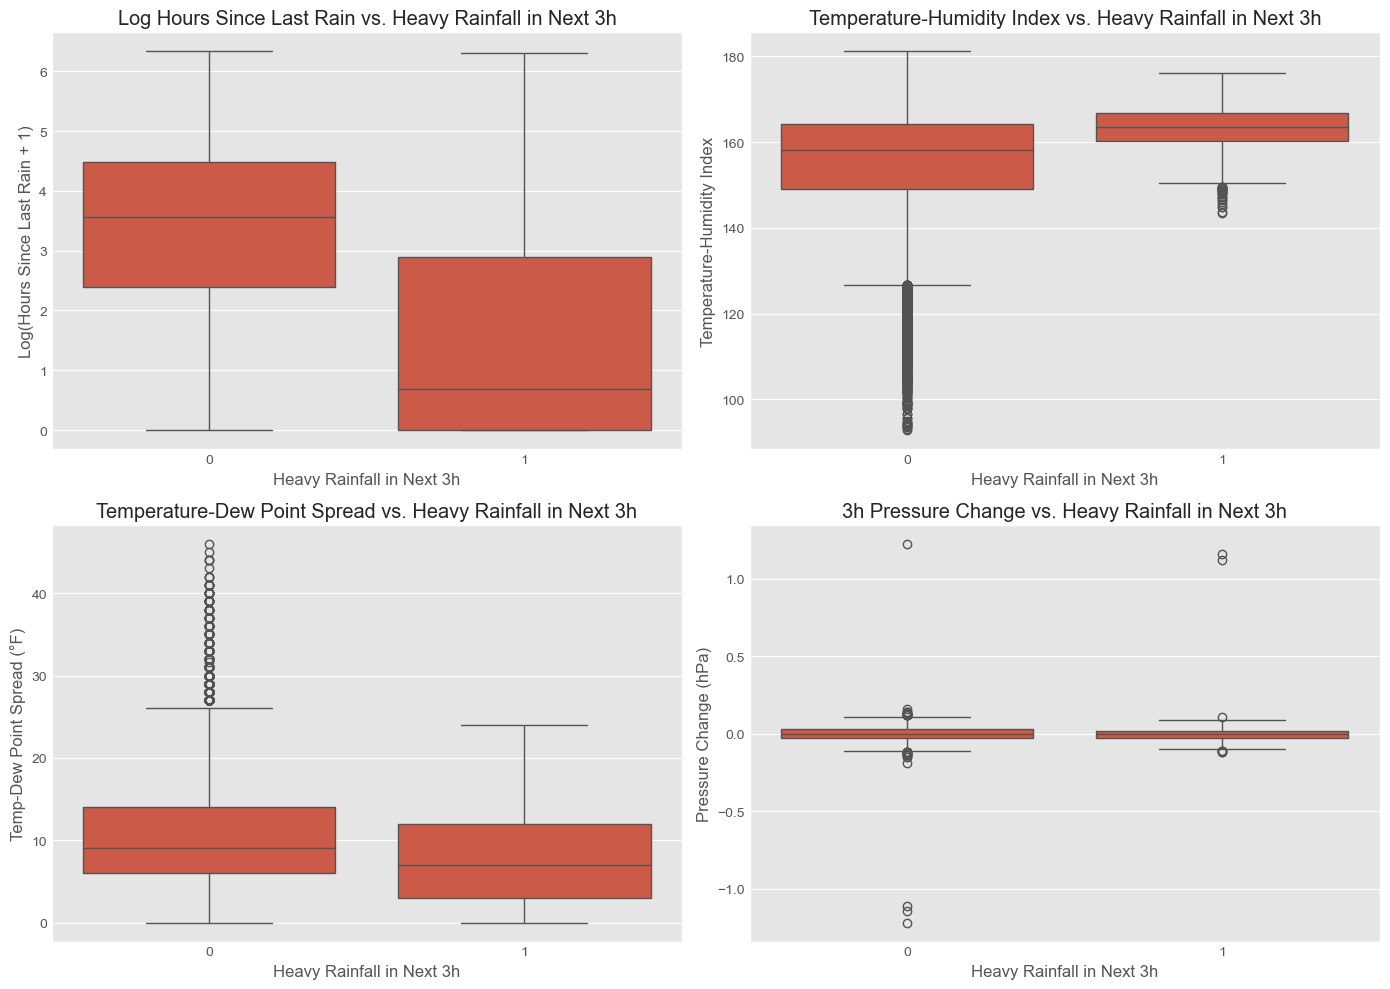

In [11]:
# ========================================
# Part 1: Data Preparation
# ========================================

# Download the preprocessed dataset
url = '/Users/yu/Desktop/Weather Data/hourly_data_complete.csv'
hourly_data = pd.read_csv(url)

# Convert the index to datetime if it contains date information
if 'Unnamed: 0' in hourly_data.columns:
    # Try to parse the first column as datetime
    try:
        hourly_data['date_index'] = pd.to_datetime(hourly_data['Unnamed: 0'])
        hourly_data = hourly_data.set_index('date_index')
        hourly_data = hourly_data.drop(columns=['Unnamed: 0'])
    except:
        # If parsing fails, just drop the unnamed column
        hourly_data = hourly_data.drop(columns=['Unnamed: 0'])

# Display basic information
print("Dataset basic information:")
print(f"Shape: {hourly_data.shape}")
print(f"Index type: {type(hourly_data.index)}")
if isinstance(hourly_data.index, pd.DatetimeIndex):
    print(f"Time range: {hourly_data.index.min()} to {hourly_data.index.max()}")
hourly_data.head()

# Check data types and missing values
print("\nData types:")
print(hourly_data.dtypes)
print("\nMissing values:")
print(hourly_data.isna().sum())

# Verify that the binary variables are computed correctly
# First, check how HeavyRainfall is defined
print("\nHeavyRainfall definition verification:")
heavy_rain_threshold = 0.4  # 0.4 inches/hour (~10 mm/hour) standard meteorological threshold

# Check if HeavyRainfall matches our expected definition
hourly_data['Expected_HeavyRainfall'] = (hourly_data['HourlyPrecipitation'] > heavy_rain_threshold).astype(int)
matching = (hourly_data['HeavyRainfall'] == hourly_data['Expected_HeavyRainfall']).mean() * 100
print(f"HeavyRainfall matches expected definition in {matching:.2f}% of cases")

# Check the 'plus' variables (these should be shifted versions of HeavyRainfall)
for i in range(1, 4):
    col_name = f'HeavyRainfall_plus_{i}h'
    matching = (hourly_data[col_name] == hourly_data['HeavyRainfall'].shift(-i)).mean() * 100
    print(f"{col_name} matches shifted HeavyRainfall in {matching:.2f}% of cases")

# Check HeavyRainfall_Next3h (should be 1 if any of the next 3 hours has heavy rainfall)
hourly_data['Expected_Next3h'] = (
    (hourly_data['HeavyRainfall_plus_1h'] == 1) | 
    (hourly_data['HeavyRainfall_plus_2h'] == 1) | 
    (hourly_data['HeavyRainfall_plus_3h'] == 1)
).astype(int)
matching = (hourly_data['HeavyRainfall_Next3h'] == hourly_data['Expected_Next3h']).mean() * 100
print(f"HeavyRainfall_Next3h matches expected definition in {matching:.2f}% of cases")

# Clean up verification columns
hourly_data = hourly_data.drop(columns=['Expected_HeavyRainfall', 'Expected_Next3h'], errors='ignore')

# Plot the distribution of precipitation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
hourly_data['HourlyPrecipitation'].plot(kind='hist', bins=50, logy=True, 
                                       color='skyblue', edgecolor='black')
plt.axvline(x=heavy_rain_threshold, color='r', linestyle='--', 
            label=f'Heavy rainfall threshold: {heavy_rain_threshold} in')
plt.title('Precipitation Distribution (Log Scale)')
plt.xlabel('Precipitation (inches/hour)')
plt.ylabel('Count (log scale)')
plt.legend()

plt.subplot(1, 2, 2)
# Zoom in on non-zero precipitation to better see distribution
non_zero = hourly_data[hourly_data['HourlyPrecipitation'] > 0]['HourlyPrecipitation']
non_zero.plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=heavy_rain_threshold, color='r', linestyle='--', 
            label=f'Heavy rainfall threshold: {heavy_rain_threshold} in')
plt.title('Non-Zero Precipitation Distribution')
plt.xlabel('Precipitation (inches/hour)')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate percentage of heavy rainfall
heavy_rain_hours = (hourly_data['HourlyPrecipitation'] > heavy_rain_threshold).sum()
total_hours = len(hourly_data)
heavy_rain_percent = heavy_rain_hours / total_hours * 100
print(f"\nHeavy rainfall statistics:")
print(f"Total hours: {total_hours}")
print(f"Hours with heavy rainfall: {heavy_rain_hours}")
print(f"Percentage of heavy rainfall: {heavy_rain_percent:.2f}%")

# Find cloudbursts in the data
# A cloudburst typically involves very heavy rainfall (higher than our threshold)
# Let's identify the top 10 heaviest rainfall events
top_events = hourly_data.sort_values('HourlyPrecipitation', ascending=False).head(10)
print("\nTop 10 heaviest rainfall events (potential cloudbursts):")
print(top_events[['HourlyPrecipitation', 'HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure']])

# Select one significant cloudburst to analyze in detail
# Choose the most intense rainfall event
cloudburst_idx = top_events.index[0]
print(f"\nAnalyzing cloudburst at {cloudburst_idx} with precipitation of {top_events.iloc[0]['HourlyPrecipitation']:.2f} inches/hour")

# Get the index position of this event to safely extract window
if isinstance(cloudburst_idx, (int, np.integer)):
    # If we have integer index
    window_start = max(0, cloudburst_idx - 24)
    window_end = min(len(hourly_data) - 1, cloudburst_idx + 24)
    cloudburst_window = hourly_data.iloc[window_start:window_end+1].copy()
    cloudburst_time = cloudburst_idx
else:
    # If we have datetime index
    cloudburst_time = pd.to_datetime(cloudburst_idx)
    start_time = cloudburst_time - pd.Timedelta(hours=24)
    end_time = cloudburst_time + pd.Timedelta(hours=24)
    cloudburst_window = hourly_data.loc[cloudburst_time].copy()  # Get just the cloudburst hour
    # Get 24h before and after by finding closest times
    before_burst = hourly_data[hourly_data.index < cloudburst_time].tail(24)
    after_burst = hourly_data[hourly_data.index > cloudburst_time].head(24)
    cloudburst_window = pd.concat([before_burst, cloudburst_window.to_frame().T, after_burst])

# Ensure the time index is properly formatted for plotting
# First make sure we have correct reference time
if isinstance(cloudburst_time, (int, np.integer)):
    # If it's an integer index, use the timestamp at that position for reference
    reference_idx = np.where(cloudburst_window.index == cloudburst_idx)[0]
    if len(reference_idx) > 0:
        reference_time = cloudburst_window.index[reference_idx[0]]
    else:
        # Use middle of the window as reference
        reference_time = cloudburst_window.index[len(cloudburst_window)//2]
else:
    reference_time = cloudburst_time

# Calculate hours from event for each timestamp
cloudburst_window['hours_from_event'] = [(t - reference_time).total_seconds()/3600 
                                        if isinstance(t, pd.Timestamp) else 0
                                        for t in cloudburst_window.index]

# Plot key variables around the cloudburst
fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True)

# Precipitation
axes[0].plot(cloudburst_window['hours_from_event'], cloudburst_window['HourlyPrecipitation'], 
             color='blue', marker='o', linestyle='-')
axes[0].axvline(x=0, color='r', linestyle='--', label='Cloudburst')
axes[0].set_ylabel('Precipitation (in/h)')
axes[0].set_title('Precipitation')
axes[0].grid(True)
axes[0].legend()

# Temperature
axes[1].plot(cloudburst_window['hours_from_event'], cloudburst_window['HourlyDryBulbTemperature'], 
             color='red', marker='o', linestyle='-')
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_ylabel('Temperature (°F)')
axes[1].set_title('Dry Bulb Temperature')
axes[1].grid(True)

# Pressure
axes[2].plot(cloudburst_window['hours_from_event'], cloudburst_window['HourlySeaLevelPressure'], 
             color='purple', marker='o', linestyle='-')
axes[2].axvline(x=0, color='r', linestyle='--')
axes[2].set_ylabel('Pressure (hPa)')
axes[2].set_title('Sea Level Pressure')
axes[2].grid(True)

# Humidity
axes[3].plot(cloudburst_window['hours_from_event'], cloudburst_window['HourlyRelativeHumidity'], 
             color='green', marker='o', linestyle='-')
axes[3].axvline(x=0, color='r', linestyle='--')
axes[3].set_ylabel('Humidity (%)')
axes[3].set_title('Relative Humidity')
axes[3].grid(True)

# Wind Speed
axes[4].plot(cloudburst_window['hours_from_event'], cloudburst_window['HourlyWindSpeed'], 
             color='orange', marker='o', linestyle='-')
axes[4].axvline(x=0, color='r', linestyle='--')
axes[4].set_xlabel('Hours from cloudburst')
axes[4].set_ylabel('Wind Speed (mph)')
axes[4].set_title('Wind Speed')
axes[4].grid(True)

plt.tight_layout()
plt.show()

# Based on the cloudburst article, implement 3-4 features that might improve prediction
# 1. Dry Period Duration (hours since last precipitation)
print("\nImplementing new features based on cloudburst mechanisms...")
hourly_data['HoursSinceLastRain'] = np.nan
rainfall_events = hourly_data['HourlyPrecipitation'] > 0
last_rain_idx = -1

for idx in range(len(hourly_data)):
    if rainfall_events.iloc[idx]:
        last_rain_idx = idx
    if last_rain_idx == -1:
        hourly_data.iloc[idx, hourly_data.columns.get_loc('HoursSinceLastRain')] = idx
    else:
        hourly_data.iloc[idx, hourly_data.columns.get_loc('HoursSinceLastRain')] = idx - last_rain_idx

# 2. Temperature-Humidity Index (discomfort index)
# This helps capture the combination of high temperature and humidity that often precedes cloudbursts
hourly_data['TempHumidityIndex'] = (0.8 * hourly_data['HourlyDryBulbTemperature'] + 
                                   hourly_data['HourlyRelativeHumidity'] / 100 * 
                                   (hourly_data['HourlyDryBulbTemperature'] - 14.3) + 46.4)

# 3. Atmospheric Instability (temp difference between surface and dew point)
hourly_data['TempDewPointSpread'] = hourly_data['HourlyDryBulbTemperature'] - hourly_data['HourlyDewPointTemperature']

# 4. Pressure Gradient (rate of change in pressure)
hourly_data['PressureChange3h'] = hourly_data['HourlySeaLevelPressure'] - hourly_data['HourlySeaLevelPressure'].shift(3)

# Create a "week" feature, sequentially numbering weeks since beginning of dataset
# First make sure we're working with datetime index
if isinstance(hourly_data.index, pd.DatetimeIndex):
    # If already datetime index
    start_date = hourly_data.index.min().to_period('W').start_time
    hourly_data['Week'] = ((hourly_data.index - start_date).total_seconds() / (7 * 24 * 3600)).astype(int)
else:
    # If integer index or other type, just use simple numbering
    # Assuming the data is hourly, each week would be 168 hours
    hourly_data['Week'] = (hourly_data.index // 168)  # Integer division by hours in a week

# Display summary of new features
print("\nSummary of new features:")
for feature in ['HoursSinceLastRain', 'TempHumidityIndex', 'TempDewPointSpread', 'PressureChange3h', 'Week']:
    print(f"{feature}: {hourly_data[feature].describe()}")

# Visualize the relationship between these features and heavy rainfall
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Hours Since Last Rain vs. Heavy Rainfall
# Use log scale for better visualization
hourly_data['LogHoursSinceRain'] = np.log1p(hourly_data['HoursSinceLastRain'])
sns.boxplot(x='HeavyRainfall_Next3h', y='LogHoursSinceRain', data=hourly_data, ax=axes[0, 0])
axes[0, 0].set_title('Log Hours Since Last Rain vs. Heavy Rainfall in Next 3h')
axes[0, 0].set_xlabel('Heavy Rainfall in Next 3h')
axes[0, 0].set_ylabel('Log(Hours Since Last Rain + 1)')

# 2. Temperature-Humidity Index vs. Heavy Rainfall
sns.boxplot(x='HeavyRainfall_Next3h', y='TempHumidityIndex', data=hourly_data, ax=axes[0, 1])
axes[0, 1].set_title('Temperature-Humidity Index vs. Heavy Rainfall in Next 3h')
axes[0, 1].set_xlabel('Heavy Rainfall in Next 3h')
axes[0, 1].set_ylabel('Temperature-Humidity Index')

# 3. Temp-Dew Point Spread vs. Heavy Rainfall
sns.boxplot(x='HeavyRainfall_Next3h', y='TempDewPointSpread', data=hourly_data, ax=axes[1, 0])
axes[1, 0].set_title('Temperature-Dew Point Spread vs. Heavy Rainfall in Next 3h')
axes[1, 0].set_xlabel('Heavy Rainfall in Next 3h')
axes[1, 0].set_ylabel('Temp-Dew Point Spread (°F)')

# 4. Pressure Change vs. Heavy Rainfall
sns.boxplot(x='HeavyRainfall_Next3h', y='PressureChange3h', data=hourly_data, ax=axes[1, 1])
axes[1, 1].set_title('3h Pressure Change vs. Heavy Rainfall in Next 3h')
axes[1, 1].set_xlabel('Heavy Rainfall in Next 3h')
axes[1, 1].set_ylabel('Pressure Change (hPa)')

plt.tight_layout()
plt.show()


Creating time-based features...

Preparing data for Random Forest modeling...
Training set: 70032 samples, 418 weeks
Testing set: 17640 samples, 105 weeks
Training set: 1.31% positive class
Testing set: 1.13% positive class

Training data after excluding weeks without precipitation:
Original training data: 70032 samples
Training data with rain weeks only: 62136 samples
Positive class percentage (original): 1.31%
Positive class percentage (rain weeks only): 1.48%
Using these features for modeling: ['HourlyPrecipitation', 'HourlyDryBulbTemperature', 'HourlyDewPointTemperature', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyWindSpeed', 'HourlyVisibility', 'Hour_sin', 'Hour_cos', 'DayOfYear_sin', 'DayOfYear_cos']

Training Random Forest Classifier...

Confusion matrix:
[[15803  1638]
 [  115    84]]
Precision: 0.0488
Recall: 0.4221

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     17441
           1 

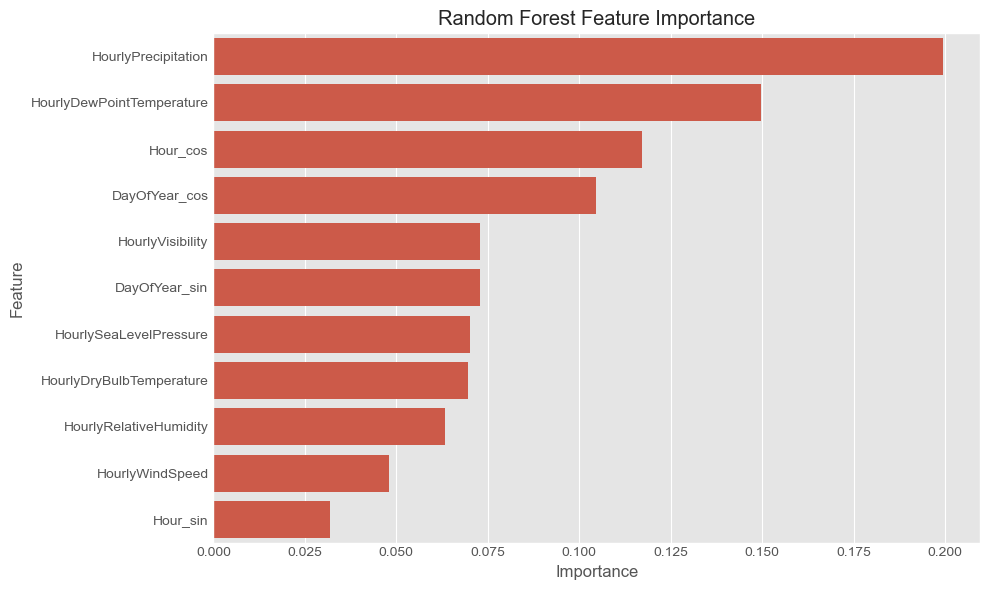


Experimenting with second-order interactions...

Confusion matrix with interactions:
[[16202  1239]
 [  117    82]]
Precision with interactions: 0.0621
Recall with interactions: 0.4121

Classification report with interactions:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     17441
           1       0.06      0.41      0.11       199

    accuracy                           0.92     17640
   macro avg       0.53      0.67      0.53     17640
weighted avg       0.98      0.92      0.95     17640



In [13]:
# ========================================
# Part 2: Random Forest Classifier
# ========================================

# First, create necessary time-based features
print("\nCreating time-based features...")
if not all(col in hourly_data.columns for col in ['Hour', 'DayOfYear']):
    # If the dataset doesn't have Hour and DayOfYear columns, create them
    if isinstance(hourly_data.index, pd.DatetimeIndex):
        hourly_data['Hour'] = hourly_data.index.hour
        hourly_data['DayOfYear'] = hourly_data.index.dayofyear
    else:
        # If we don't have datetime index, create dummy hourly pattern
        hourly_data['Hour'] = np.arange(len(hourly_data)) % 24
        hourly_data['DayOfYear'] = (np.arange(len(hourly_data)) // 24) % 365

# Convert cyclical features to sine/cosine representations
hourly_data['Hour_sin'] = np.sin(2 * np.pi * hourly_data['Hour'] / 24)
hourly_data['Hour_cos'] = np.cos(2 * np.pi * hourly_data['Hour'] / 24)
hourly_data['DayOfYear_sin'] = np.sin(2 * np.pi * hourly_data['DayOfYear'] / 365)
hourly_data['DayOfYear_cos'] = np.cos(2 * np.pi * hourly_data['DayOfYear'] / 365)

# Split data into training and testing sets by assigning whole weeks (cluster sampling)
print("\nPreparing data for Random Forest modeling...")
weeks = hourly_data['Week'].unique()
np.random.seed(42)  # For reproducibility
train_weeks = np.random.choice(weeks, size=int(0.8 * len(weeks)), replace=False)
test_weeks = np.array([week for week in weeks if week not in train_weeks])

# Create training and testing sets
train_data = hourly_data[hourly_data['Week'].isin(train_weeks)]
test_data = hourly_data[hourly_data['Week'].isin(test_weeks)]

print(f"Training set: {len(train_data)} samples, {len(train_weeks)} weeks")
print(f"Testing set: {len(test_data)} samples, {len(test_weeks)} weeks")

# Check the class distribution in each set
train_positive = train_data['HeavyRainfall_Next3h'].mean() * 100
test_positive = test_data['HeavyRainfall_Next3h'].mean() * 100
print(f"Training set: {train_positive:.2f}% positive class")
print(f"Testing set: {test_positive:.2f}% positive class")

# Address class imbalance by excluding weeks without precipitation from training
# First approach: keep original training data
X_train_full = train_data.copy()

# Second approach: exclude weeks with no precipitation
train_weeks_with_rain = train_data.groupby('Week')['HourlyPrecipitation'].max().reset_index()
rain_weeks = train_weeks_with_rain[train_weeks_with_rain['HourlyPrecipitation'] > 0]['Week'].values
X_train_rain_only = train_data[train_data['Week'].isin(rain_weeks)]

print(f"\nTraining data after excluding weeks without precipitation:")
print(f"Original training data: {len(X_train_full)} samples")
print(f"Training data with rain weeks only: {len(X_train_rain_only)} samples")
print(f"Positive class percentage (original): {X_train_full['HeavyRainfall_Next3h'].mean() * 100:.2f}%")
print(f"Positive class percentage (rain weeks only): {X_train_rain_only['HeavyRainfall_Next3h'].mean() * 100:.2f}%")

# Select features for modeling
basic_features = [
    'HourlyPrecipitation', 'HourlyDryBulbTemperature', 'HourlyDewPointTemperature',
    'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyWindSpeed',
    'HourlyVisibility', 'Hour_sin', 'Hour_cos', 'DayOfYear_sin', 'DayOfYear_cos'
]

# Check if all basic features exist in the dataset
available_features = [col for col in basic_features if col in hourly_data.columns]
missing_features = [col for col in basic_features if col not in hourly_data.columns]

if missing_features:
    print(f"Warning: The following features are missing: {missing_features}")
    print("Continuing with available features only.")
    basic_features = available_features

print(f"Using these features for modeling: {basic_features}")

cloudburst_features = [
    'HoursSinceLastRain', 'LogHoursSinceRain', 'TempHumidityIndex', 
    'TempDewPointSpread', 'PressureChange3h'
]

# Create feature sets - using only available columns
X_train = X_train_rain_only[basic_features].copy()
y_train = X_train_rain_only['HeavyRainfall_Next3h'].copy()

X_test = test_data[basic_features].copy()
y_test = test_data['HeavyRainfall_Next3h'].copy()

# Fill missing values
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
print("\nTraining Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, 
                                  class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:")
print(conf_matrix)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# Visualization of feature importance
feature_importance = pd.DataFrame({
    'Feature': basic_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

# Experiment with adding second-order interactions
print("\nExperimenting with second-order interactions...")

# Create interaction features
X_train_with_interactions = X_train.copy()
X_test_with_interactions = X_test.copy()

# Add interactions between precipitation and temperature/humidity
X_train_with_interactions['Precip_x_Temp'] = X_train['HourlyPrecipitation'] * X_train['HourlyDryBulbTemperature']
X_test_with_interactions['Precip_x_Temp'] = X_test['HourlyPrecipitation'] * X_test['HourlyDryBulbTemperature']

X_train_with_interactions['Precip_x_Humidity'] = X_train['HourlyPrecipitation'] * X_train['HourlyRelativeHumidity']
X_test_with_interactions['Precip_x_Humidity'] = X_test['HourlyPrecipitation'] * X_test['HourlyRelativeHumidity']

# Add interactions between temperature and humidity
X_train_with_interactions['Temp_x_Humidity'] = X_train['HourlyDryBulbTemperature'] * X_train['HourlyRelativeHumidity']
X_test_with_interactions['Temp_x_Humidity'] = X_test['HourlyDryBulbTemperature'] * X_test['HourlyRelativeHumidity']

# Add interactions between pressure and wind
X_train_with_interactions['Pressure_x_Wind'] = X_train['HourlySeaLevelPressure'] * X_train['HourlyWindSpeed']
X_test_with_interactions['Pressure_x_Wind'] = X_test['HourlySeaLevelPressure'] * X_test['HourlyWindSpeed']

# Standardize features
X_train_interactions_scaled = StandardScaler().fit_transform(X_train_with_interactions)
X_test_interactions_scaled = StandardScaler().fit_transform(X_test_with_interactions)

# Train Random Forest with interactions
rf_model_interactions = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, 
                                              class_weight='balanced')
rf_model_interactions.fit(X_train_interactions_scaled, y_train)

# Make predictions
y_pred_interactions = rf_model_interactions.predict(X_test_interactions_scaled)

# Evaluate the model
conf_matrix_interactions = confusion_matrix(y_test, y_pred_interactions)
print("\nConfusion matrix with interactions:")
print(conf_matrix_interactions)

precision_interactions = precision_score(y_test, y_pred_interactions)
recall_interactions = recall_score(y_test, y_pred_interactions)
print(f"Precision with interactions: {precision_interactions:.4f}")
print(f"Recall with interactions: {recall_interactions:.4f}")
print("\nClassification report with interactions:")
print(classification_report(y_test, y_pred_interactions))


Analyzing Dry Period Duration feature...


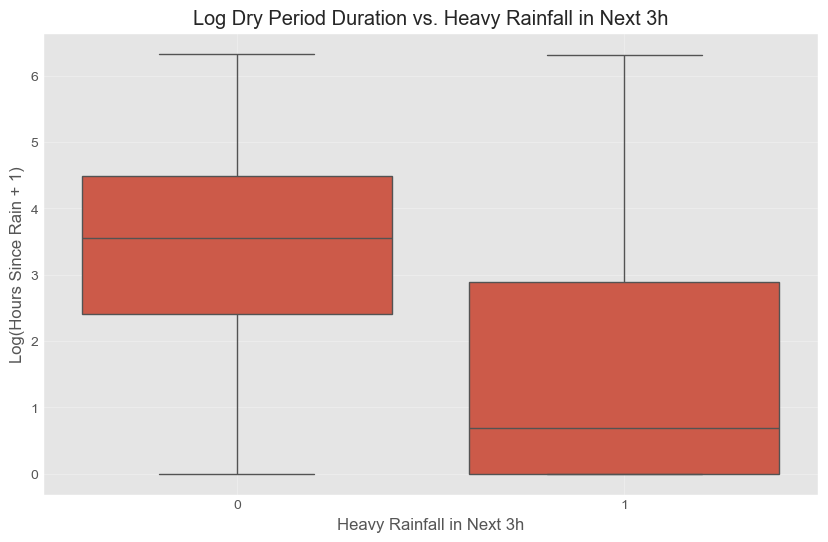

Correlation between LogDryPeriod and HeavyRainfall_Next3h: -0.1351

Training Random Forest with Dry Period feature...

Confusion matrix with dry period feature:
[[16124  1317]
 [  130    69]]
Precision with dry period: 0.0498
Recall with dry period: 0.3467

Classification report with dry period:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     17441
           1       0.05      0.35      0.09       199

    accuracy                           0.92     17640
   macro avg       0.52      0.64      0.52     17640
weighted avg       0.98      0.92      0.95     17640



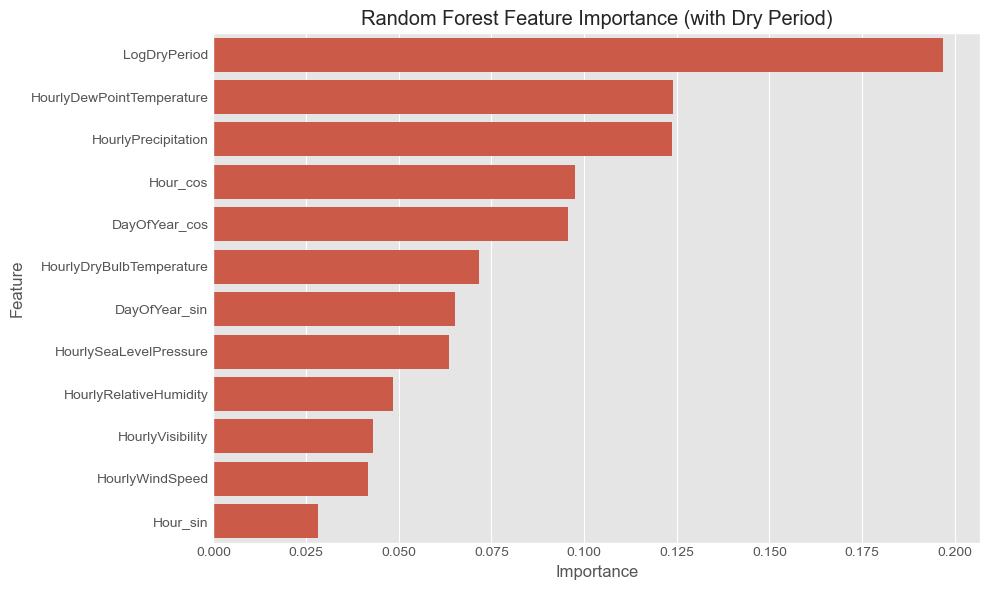


Model comparison:
               Model  Precision    Recall
0              Basic   0.048780  0.422111
1  With Interactions   0.062074  0.412060
2    With Dry Period   0.049784  0.346734


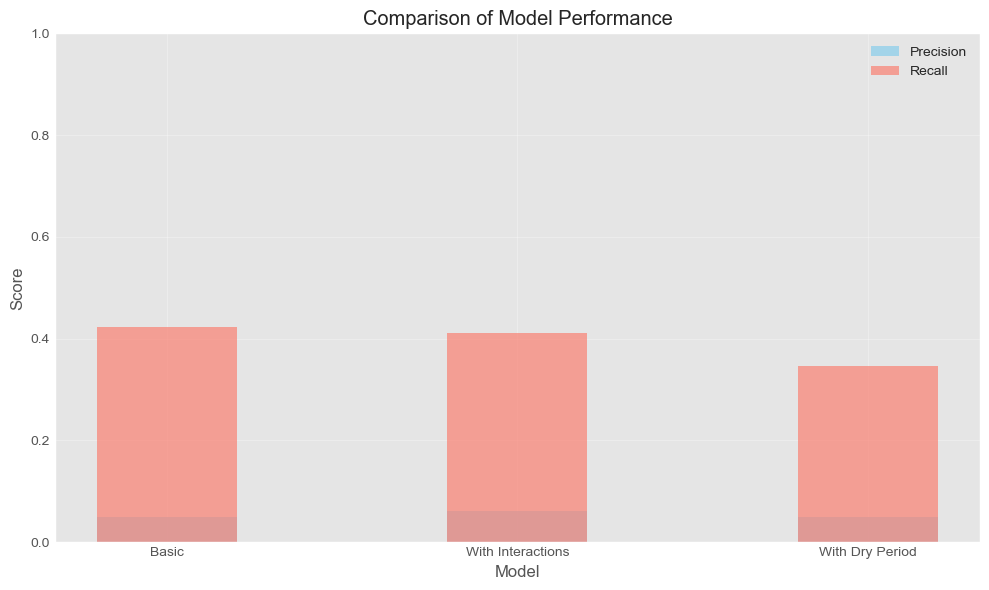

In [15]:
# ========================================
# Part 3: Dry Period Duration Analysis
# ========================================

print("\nAnalyzing Dry Period Duration feature...")

# Ensure we have the LogDryPeriod feature
if 'LogHoursSinceRain' in hourly_data.columns:
    # We already created this feature before
    hourly_data['LogDryPeriod'] = hourly_data['LogHoursSinceRain']
else:
    # Calculate the dry period duration feature as specified
    # First make sure HoursSinceLastRain exists
    if 'HoursSinceLastRain' not in hourly_data.columns:
        print("Creating HoursSinceLastRain feature...")
        hourly_data['HoursSinceLastRain'] = np.nan
        rainfall_events = hourly_data['HourlyPrecipitation'] > 0
        last_rain_idx = -1

        for idx in range(len(hourly_data)):
            if rainfall_events.iloc[idx]:
                last_rain_idx = idx
            if last_rain_idx == -1:
                hourly_data.iloc[idx, hourly_data.columns.get_loc('HoursSinceLastRain')] = idx
            else:
                hourly_data.iloc[idx, hourly_data.columns.get_loc('HoursSinceLastRain')] = idx - last_rain_idx
    
    # Now create the log-transformed feature
    hourly_data['LogDryPeriod'] = np.log1p(hourly_data['HoursSinceLastRain'])  # log(hours_since_rain + 1)

# Visualize the relationship between dry period duration and heavy rainfall
plt.figure(figsize=(10, 6))
sns.boxplot(x='HeavyRainfall_Next3h', y='LogDryPeriod', data=hourly_data)
plt.title('Log Dry Period Duration vs. Heavy Rainfall in Next 3h')
plt.xlabel('Heavy Rainfall in Next 3h')
plt.ylabel('Log(Hours Since Rain + 1)')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate correlation
corr = hourly_data[['LogDryPeriod', 'HeavyRainfall_Next3h']].corr().iloc[0, 1]
print(f"Correlation between LogDryPeriod and HeavyRainfall_Next3h: {corr:.4f}")

# Add dry period feature to Random Forest model
print("\nTraining Random Forest with Dry Period feature...")

# Create feature sets with LogDryPeriod feature
# Make sure to only include features that exist in our dataframes
dry_period_features = basic_features + ['LogDryPeriod']

# Make sure all features exist in both train and test data
X_train_rain_only['LogDryPeriod'] = X_train_rain_only['LogHoursSinceRain'] if 'LogHoursSinceRain' in X_train_rain_only.columns else np.log1p(X_train_rain_only['HoursSinceLastRain'])
test_data['LogDryPeriod'] = test_data['LogHoursSinceRain'] if 'LogHoursSinceRain' in test_data.columns else np.log1p(test_data['HoursSinceLastRain'])

X_train_dry = X_train_rain_only[dry_period_features].copy()
X_test_dry = test_data[dry_period_features].copy()

# Fill missing values
X_train_dry = X_train_dry.fillna(X_train_dry.median())
X_test_dry = X_test_dry.fillna(X_test_dry.median())

# Standardize features
X_train_dry_scaled = StandardScaler().fit_transform(X_train_dry)
X_test_dry_scaled = StandardScaler().fit_transform(X_test_dry)

# Train Random Forest with dry period
rf_model_dry = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42,
                                     class_weight='balanced')
rf_model_dry.fit(X_train_dry_scaled, y_train)

# Make predictions
y_pred_dry = rf_model_dry.predict(X_test_dry_scaled)

# Evaluate the model
conf_matrix_dry = confusion_matrix(y_test, y_pred_dry)
print("\nConfusion matrix with dry period feature:")
print(conf_matrix_dry)

precision_dry = precision_score(y_test, y_pred_dry)
recall_dry = recall_score(y_test, y_pred_dry)
print(f"Precision with dry period: {precision_dry:.4f}")
print(f"Recall with dry period: {recall_dry:.4f}")
print("\nClassification report with dry period:")
print(classification_report(y_test, y_pred_dry))

# Visualize feature importance with dry period feature
feature_importance_dry = pd.DataFrame({
    'Feature': dry_period_features,
    'Importance': rf_model_dry.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_dry)
plt.title('Random Forest Feature Importance (with Dry Period)')
plt.tight_layout()
plt.show()

# Compare models side-by-side
print("\nModel comparison:")
results = pd.DataFrame({
    'Model': ['Basic', 'With Interactions', 'With Dry Period'],
    'Precision': [precision, precision_interactions, precision_dry],
    'Recall': [recall, recall_interactions, recall_dry]
})
print(results)

plt.figure(figsize=(10, 6))
plt.bar(results['Model'], results['Precision'], width=0.4, label='Precision', alpha=0.7, color='skyblue')
plt.bar(results['Model'], results['Recall'], width=0.4, label='Recall', alpha=0.7, color='salmon')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Comparison of Model Performance')
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



==== Part 4: Improved Models for Heavy Rainfall Prediction ====

1. Creating enhanced features...

2. Preparing data with advanced features...
Using 34 out of 34 enhanced features

3. Training advanced models...

Model: Random Forest
Threshold: 0.5
Confusion Matrix:
[[16938   503]
 [  156    43]]
Precision: 0.0788
Recall: 0.2161
F1 Score: 0.1154
ROC-AUC: 0.8677
PR-AUC: 0.0708

Model: Gradient Boosting
Threshold: 0.5
Confusion Matrix:
[[17374    67]
 [  195     4]]
Precision: 0.0563
Recall: 0.0201
F1 Score: 0.0296
ROC-AUC: 0.8478
PR-AUC: 0.0579

Model: XGBoost
Threshold: 0.5
Confusion Matrix:
[[16684   757]
 [  149    50]]
Precision: 0.0620
Recall: 0.2513
F1 Score: 0.0994
ROC-AUC: 0.8132
PR-AUC: 0.0468
[LightGBM] [Info] Number of positive: 920, number of negative: 69112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

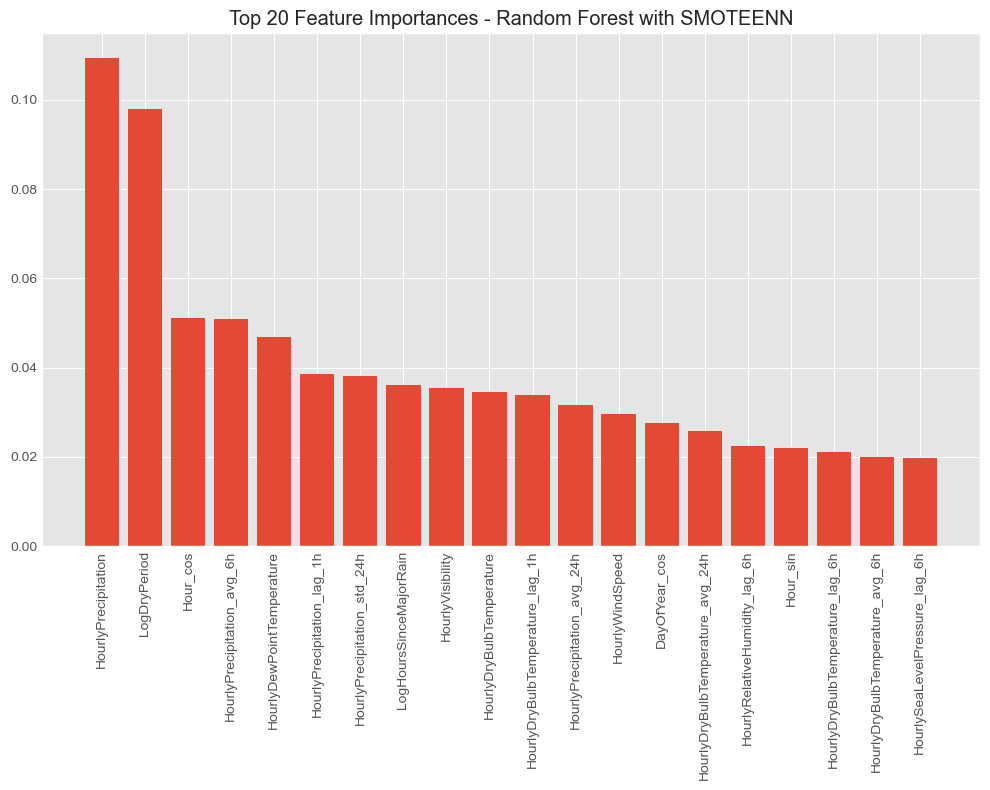


7. Final model performance...

Final Model Performance:
Model: Random Forest with SMOTEENN
Threshold: 0.50
Confusion Matrix:
[[17188   253]
 [  154    45]]
Precision: 0.1510
Recall: 0.2261
F1 Score: 0.1811
ROC-AUC: 0.8753
PR-AUC: 0.0901

Improvement over baseline Random Forest:
Precision: 91.74%
Recall: 4.65%
F1 Score: 56.87%

Analysis complete!


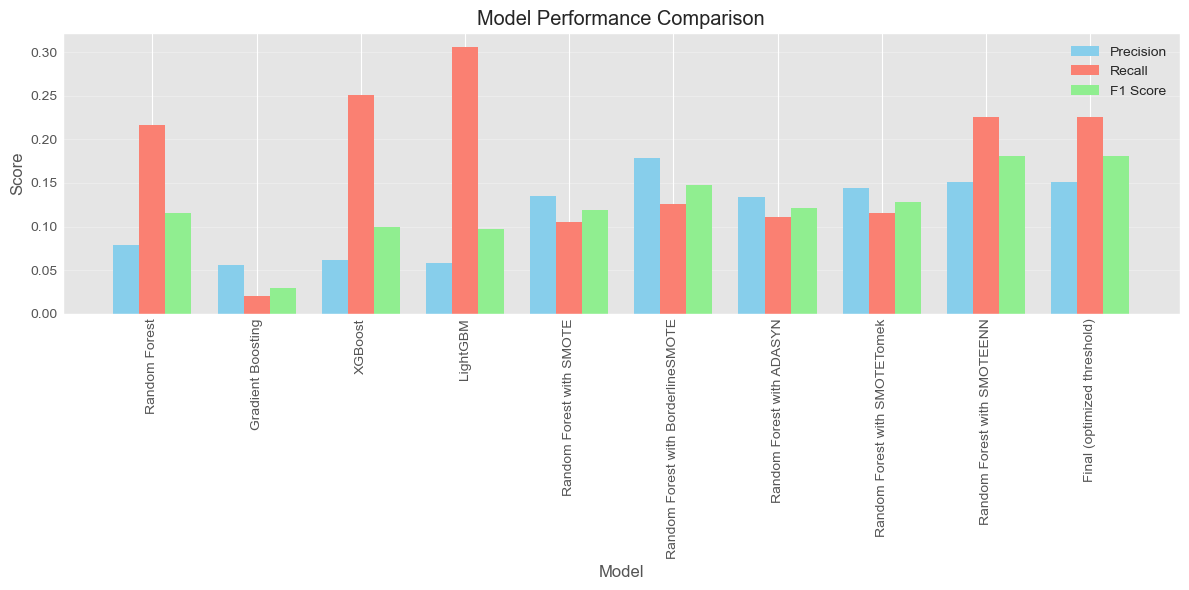

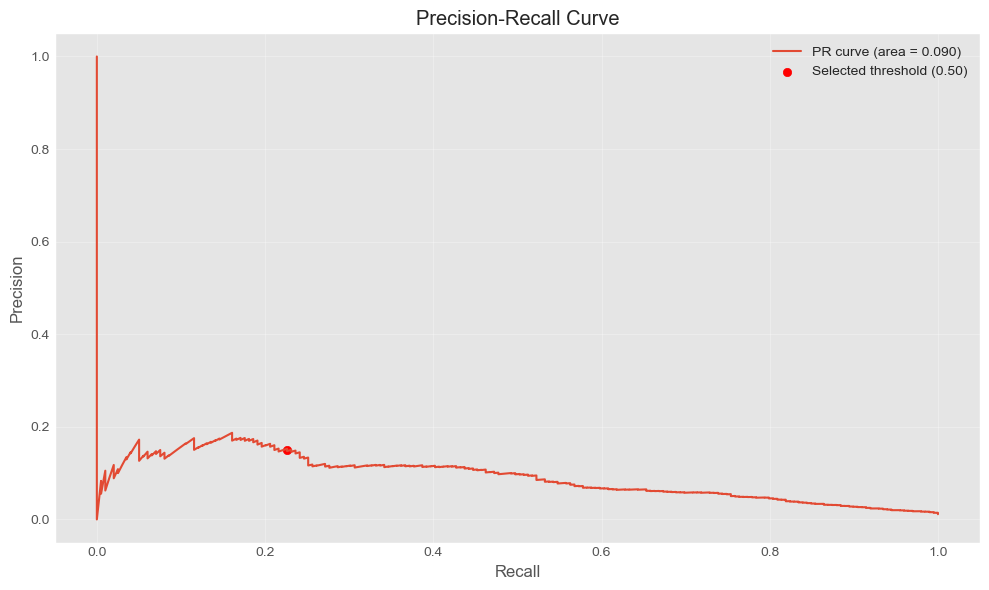

In [18]:
# Improved Heavy Rainfall Prediction Models
# ========================================

# Import additional libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
import warnings
warnings.filterwarnings('ignore')

# ========================================
# Part 4: Advanced Models for Imbalanced Time Series
# ========================================

print("\n==== Part 4: Improved Models for Heavy Rainfall Prediction ====")

# ---------------
# 1. Enhanced Feature Engineering
# ---------------

print("\n1. Creating enhanced features...")

# Create weather pattern features (changes over different time periods)
for col in ['HourlyPrecipitation', 'HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure']:
    # Create lagged features
    for lag in [1, 3, 6, 12]:
        hourly_data[f'{col}_lag_{lag}h'] = hourly_data[col].shift(lag)
    
    # Create moving averages
    for window in [3, 6, 12, 24]:
        hourly_data[f'{col}_avg_{window}h'] = hourly_data[col].rolling(window=window, min_periods=1).mean()
    
    # Create moving standard deviations (volatility)
    for window in [6, 12, 24]:
        hourly_data[f'{col}_std_{window}h'] = hourly_data[col].rolling(window=window, min_periods=3).std()

# Create humidity-temperature interaction feature (captures moisture content)
hourly_data['MoistureContent'] = hourly_data['HourlyRelativeHumidity'] * hourly_data['HourlyDryBulbTemperature'] / 100

# Create pressure change rate
hourly_data['PressureChangeRate'] = hourly_data['HourlySeaLevelPressure'].diff() / hourly_data['HourlySeaLevelPressure'].shift(1) * 100

# Create daily precipitation cycle (time since last major rain)
hourly_data['HoursSinceMajorRain'] = np.nan
major_rain_events = hourly_data['HourlyPrecipitation'] > 0.1  # More than light rain
last_major_rain_idx = -1

for idx in range(len(hourly_data)):
    if major_rain_events.iloc[idx]:
        last_major_rain_idx = idx
    if last_major_rain_idx == -1:
        hourly_data.iloc[idx, hourly_data.columns.get_loc('HoursSinceMajorRain')] = idx
    else:
        hourly_data.iloc[idx, hourly_data.columns.get_loc('HoursSinceMajorRain')] = idx - last_major_rain_idx

hourly_data['LogHoursSinceMajorRain'] = np.log1p(hourly_data['HoursSinceMajorRain'])

# Create seasonal features
if 'Month' in hourly_data.columns:
    # Wet season indicator (adjust months based on Florida climate)
    hourly_data['WetSeason'] = hourly_data['Month'].isin([5, 6, 7, 8, 9, 10]).astype(int)
else:
    # If we don't have Month column, create it from datetime index if available
    if isinstance(hourly_data.index, pd.DatetimeIndex):
        hourly_data['Month'] = hourly_data.index.month
        hourly_data['WetSeason'] = hourly_data['Month'].isin([5, 6, 7, 8, 9, 10]).astype(int)
    else:
        print("Warning: Cannot create seasonal features without datetime information")

# ---------------
# 2. Prepare Data for Advanced Models
# ---------------

print("\n2. Preparing data with advanced features...")

# Define enhanced feature sets
enhanced_features = [
    # Basic features
    'HourlyPrecipitation', 'HourlyDryBulbTemperature', 'HourlyDewPointTemperature',
    'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyWindSpeed',
    'HourlyVisibility', 'Hour_sin', 'Hour_cos', 'DayOfYear_sin', 'DayOfYear_cos',
    
    # Lag features (1-hour and 6-hour lags)
    'HourlyPrecipitation_lag_1h', 'HourlyPrecipitation_lag_6h',
    'HourlyDryBulbTemperature_lag_1h', 'HourlyDryBulbTemperature_lag_6h',
    'HourlyRelativeHumidity_lag_1h', 'HourlyRelativeHumidity_lag_6h',
    'HourlySeaLevelPressure_lag_1h', 'HourlySeaLevelPressure_lag_6h',
    
    # Moving averages
    'HourlyPrecipitation_avg_6h', 'HourlyPrecipitation_avg_24h',
    'HourlyDryBulbTemperature_avg_6h', 'HourlyDryBulbTemperature_avg_24h',
    'HourlyRelativeHumidity_avg_6h', 'HourlyRelativeHumidity_avg_24h',
    'HourlySeaLevelPressure_avg_6h', 'HourlySeaLevelPressure_avg_24h',
    
    # Volatility features
    'HourlyPrecipitation_std_24h', 'HourlySeaLevelPressure_std_24h',
    
    # Derived features
    'MoistureContent', 'PressureChangeRate', 'LogHoursSinceMajorRain', 'LogDryPeriod'
]

# Add wet season if available
if 'WetSeason' in hourly_data.columns:
    enhanced_features.append('WetSeason')

# Filter to only include features that exist in the dataframe
available_enhanced_features = [f for f in enhanced_features if f in hourly_data.columns]
print(f"Using {len(available_enhanced_features)} out of {len(enhanced_features)} enhanced features")

# Split data using the same weekly split approach as before
train_data = hourly_data[hourly_data['Week'].isin(train_weeks)]
test_data = hourly_data[hourly_data['Week'].isin(test_weeks)]

# Create X and y sets
X_train_enhanced = train_data[available_enhanced_features].copy()
y_train = train_data['HeavyRainfall_Next3h'].copy()

X_test_enhanced = test_data[available_enhanced_features].copy()
y_test = test_data['HeavyRainfall_Next3h'].copy()

# Handle missing values
X_train_enhanced = X_train_enhanced.fillna(X_train_enhanced.median())
X_test_enhanced = X_test_enhanced.fillna(X_train_enhanced.median())  # Use training medians for test set

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enhanced)
X_test_scaled = scaler.transform(X_test_enhanced)

# ---------------
# 3. Try Different Advanced Models
# ---------------

print("\n3. Training advanced models...")

# Function to evaluate and store model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, threshold=0.5):
    # Train model
    model.fit(X_train, y_train)
    
    # Get predictions (probabilities)
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = None
    
    # Calculate metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate ROC-AUC if probabilities are available
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Calculate PR-AUC if probabilities are available
    if y_pred_proba is not None:
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_curve, precision_curve)
    else:
        pr_auc = None
    
    # Print results
    print(f"\nModel: {model_name}")
    print(f"Threshold: {threshold}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.4f}")
    if pr_auc is not None:
        print(f"PR-AUC: {pr_auc:.4f}")
    
    # Return results
    return {
        'model_name': model_name,
        'confusion_matrix': conf_matrix,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'model': model,
        'threshold': threshold
    }

# Define models to try
models = [
    ('Random Forest', RandomForestClassifier(n_estimators=200, max_depth=15, 
                                            class_weight='balanced', random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=200, max_depth=5, 
                                                   learning_rate=0.1, random_state=42)),
    ('XGBoost', XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, 
                             scale_pos_weight=50, random_state=42)),
    ('LightGBM', LGBMClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, 
                               class_weight='balanced', random_state=42)),
]

# Store results
results = []

# Train and evaluate each model
for name, model in models:
    result = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results.append(result)

# ---------------
# 4. Advanced Resampling Techniques
# ---------------

print("\n4. Applying advanced resampling techniques...")

# Define resampling techniques to try
resampling_techniques = [
    ('SMOTE', SMOTE(sampling_strategy=0.25, random_state=42)),  # Create minority samples to be 25% of majority
    ('BorderlineSMOTE', BorderlineSMOTE(sampling_strategy=0.25, random_state=42)),
    ('ADASYN', ADASYN(sampling_strategy=0.25, random_state=42)),
    ('SMOTETomek', SMOTETomek(sampling_strategy=0.25, random_state=42)),
    ('SMOTEENN', SMOTEENN(sampling_strategy=0.25, random_state=42))
]

# Use the best model from previous step
best_model_idx = max(range(len(results)), key=lambda i: results[i]['f1'])
best_model_name = results[best_model_idx]['model_name']
best_model = results[best_model_idx]['model']

print(f"\nUsing {best_model_name} as base model for resampling techniques")

# Apply each resampling technique
resampling_results = []
for name, resampler in resampling_techniques:
    print(f"\nApplying {name}...")
    
    # Resample the training data
    X_resampled, y_resampled = resampler.fit_resample(X_train_scaled, y_train)
    
    # Create a new model of the same type
    if best_model_name == 'Random Forest':
        model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
    elif best_model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
    elif best_model_name == 'XGBoost':
        model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
    elif best_model_name == 'LightGBM':
        model = LGBMClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
    
    # Train and evaluate
    result = evaluate_model(model, X_resampled, X_test_scaled, y_resampled, y_test, f"{best_model_name} with {name}")
    resampling_results.append(result)

# ---------------
# 5. Threshold Optimization
# ---------------

print("\n5. Optimizing decision thresholds...")

# Find the best resampling technique
best_resampling_idx = max(range(len(resampling_results)), key=lambda i: resampling_results[i]['f1'])
best_resampling = resampling_results[best_resampling_idx]['model_name']

# Use the model from the best resampling technique
best_model = resampling_results[best_resampling_idx]['model']

# Get predicted probabilities
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Try different thresholds
thresholds = np.arange(0.05, 0.55, 0.05)
threshold_results = []

for threshold in thresholds:
    # Convert probabilities to binary predictions using the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print results
    print(f"\nThreshold: {threshold:.2f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Store results
    threshold_results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# Find the best threshold based on F1 score
best_threshold_idx = max(range(len(threshold_results)), key=lambda i: threshold_results[i]['f1'])
best_threshold = threshold_results[best_threshold_idx]['threshold']

print(f"\nBest threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {threshold_results[best_threshold_idx]['f1']:.4f}")
print(f"Corresponding Precision: {threshold_results[best_threshold_idx]['precision']:.4f}")
print(f"Corresponding Recall: {threshold_results[best_threshold_idx]['recall']:.4f}")

# ---------------
# 6. Feature Importance Analysis
# ---------------

print("\n6. Analyzing feature importance...")

# Get feature importances if available
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("\nFeature ranking:")
    
    for i in range(min(20, len(available_enhanced_features))):
        print(f"{i+1}. {available_enhanced_features[indices[i]]} ({importances[indices[i]]:.4f})")
    
    # Plot feature importances
    plt.figure(figsize=(10, 8))
    plt.title(f"Top 20 Feature Importances - {best_resampling}")
    plt.bar(range(min(20, len(available_enhanced_features))), 
            importances[indices[:20]], align="center")
    plt.xticks(range(min(20, len(available_enhanced_features))), 
              [available_enhanced_features[i] for i in indices[:20]], rotation=90)
    plt.tight_layout()
    plt.show()

# ---------------
# 7. Final Model Performance
# ---------------

print("\n7. Final model performance...")

# Use the best model with the best threshold
y_pred_final = (y_pred_proba >= best_threshold).astype(int)

# Calculate final metrics
conf_matrix = confusion_matrix(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
roc_auc = roc_auc_score(y_test, y_pred_proba)

precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

# Print final results
print("\nFinal Model Performance:")
print(f"Model: {best_resampling}")
print(f"Threshold: {best_threshold:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

# Calculate improvement over baseline
baseline_precision = results[0]['precision']  # Random Forest without resampling
baseline_recall = results[0]['recall']
baseline_f1 = results[0]['f1']

print(f"\nImprovement over baseline Random Forest:")
print(f"Precision: {precision/baseline_precision - 1:.2%}")
print(f"Recall: {recall/baseline_recall - 1:.2%}")
print(f"F1 Score: {f1/baseline_f1 - 1:.2%}")

print("\nAnalysis complete!")

# ---------------
# 8. Visualization of Results
# ---------------

# Compare all models
model_names = [r['model_name'] for r in results + resampling_results] + ['Final (optimized threshold)']
precisions = [r['precision'] for r in results + resampling_results] + [precision]
recalls = [r['recall'] for r in results + resampling_results] + [recall]
f1_scores = [r['f1'] for r in results + resampling_results] + [f1]

plt.figure(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.25

plt.bar(x - width, precisions, width, label='Precision', color='skyblue')
plt.bar(x, recalls, width, label='Recall', color='salmon')
plt.bar(x + width, f1_scores, width, label='F1 Score', color='lightgreen')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names, rotation=90)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, label=f'PR curve (area = {pr_auc:.3f})')
plt.scatter([recall], [precision], color='red', marker='o', 
           label=f'Selected threshold ({best_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


==== Part 5: Two-Stage Classification Strategy ====

1. Preparing data and enhanced features...

2. Creating two-stage target variables...
Any rainfall in next 3h: 8589 instances (9.80%)
Heavy rainfall in next 3h: 1119 instances (1.28%)
Conditional probability of heavy rain given any rain: 13.03%

3. Implementing data splitting strategy...
Training set: 70032 samples, 9.65% any rain, 1.31% heavy rain
Testing set: 17640 samples, 10.39% any rain, 1.13% heavy rain

4. Defining feature sets for both classification stages...
Stage 1 (Any Rain): Using 17 features
Stage 2 (Heavy Rain): Using 21 features

5. Preparing data for Stage 1 (Any Rainfall Prediction)...
Original Stage 1 training data: 70032 samples, 9.65% positive class
Resampled Stage 1 training data: 94912 samples, 33.33% positive class

6. Training Stage 1 Model (Any Rainfall Prediction)...
Stage 1 - Threshold 0.2: Precision 0.1987, Recall 0.8581, F1 0.3226
Stage 1 - Threshold 0.3: Precision 0.2681, Recall 0.7462, F1 0.3945
Stage

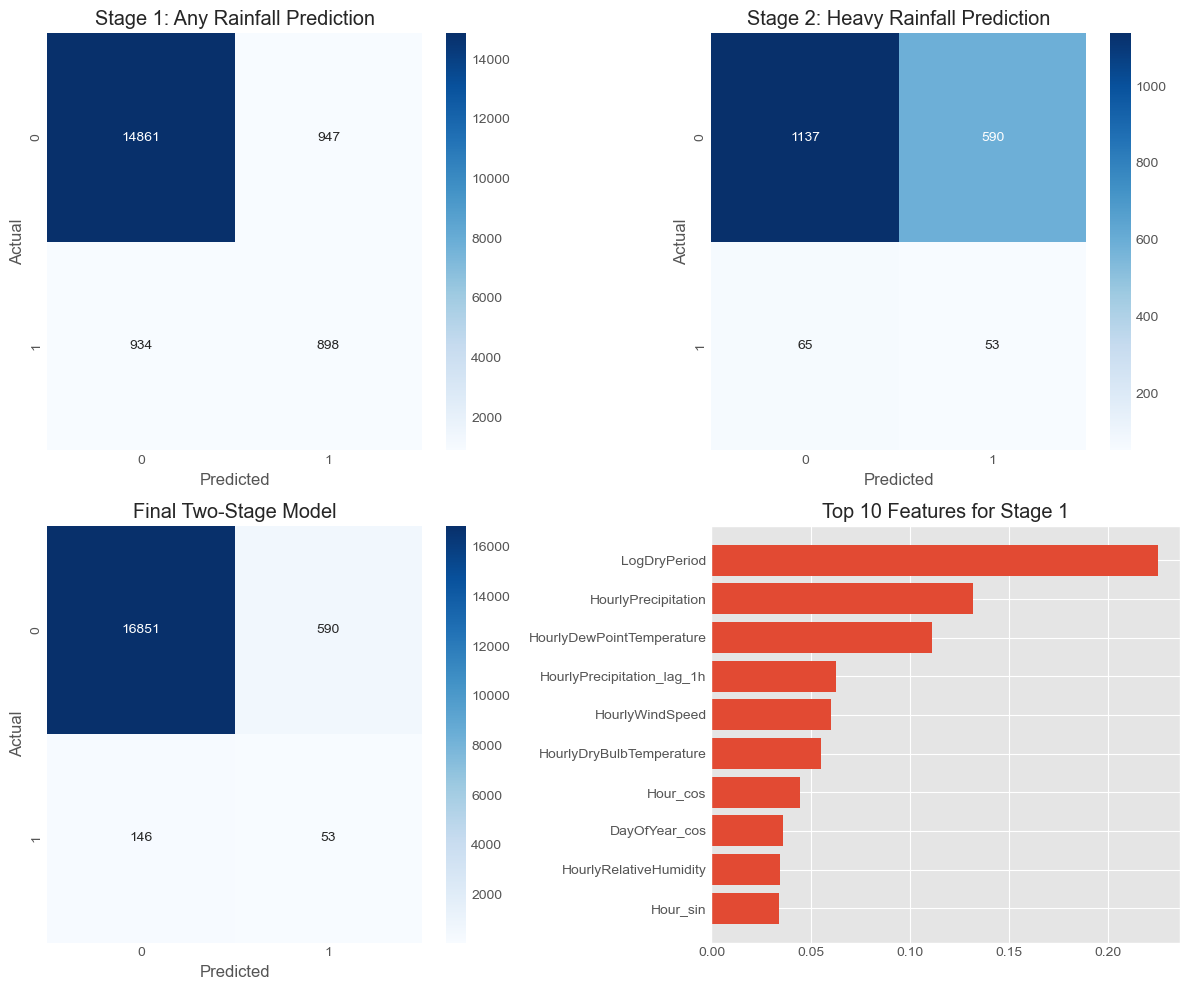

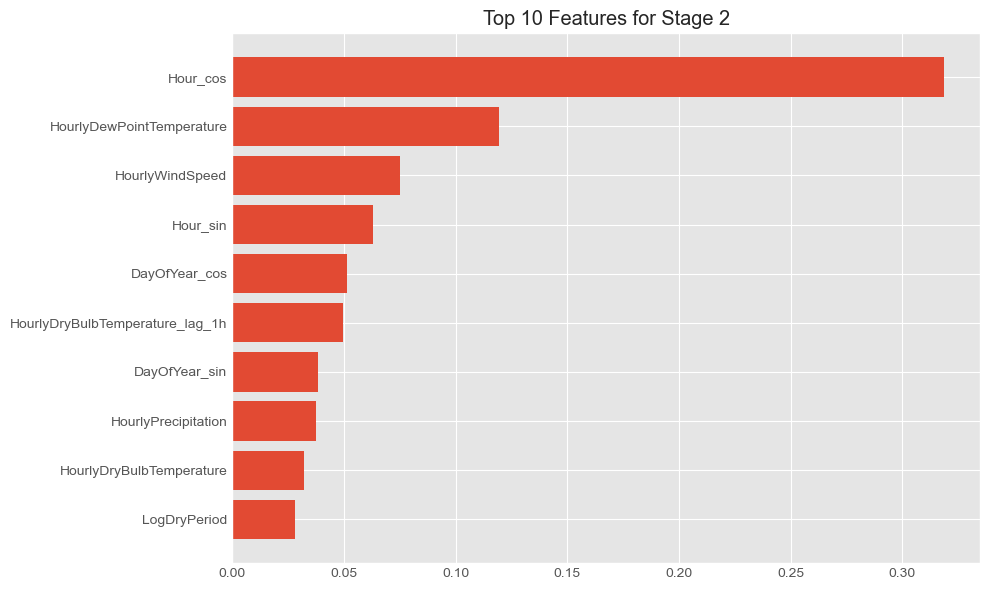


12. Comparing with previous approaches...

Model Comparison:
                         Model  Precision    Recall  F1 Score
0     Random Forest (original)   0.079200  0.216100  0.115300
1  Random Forest with SMOTEENN   0.151000  0.226100  0.181100
2              Two-Stage Model   0.082426  0.266332  0.125891


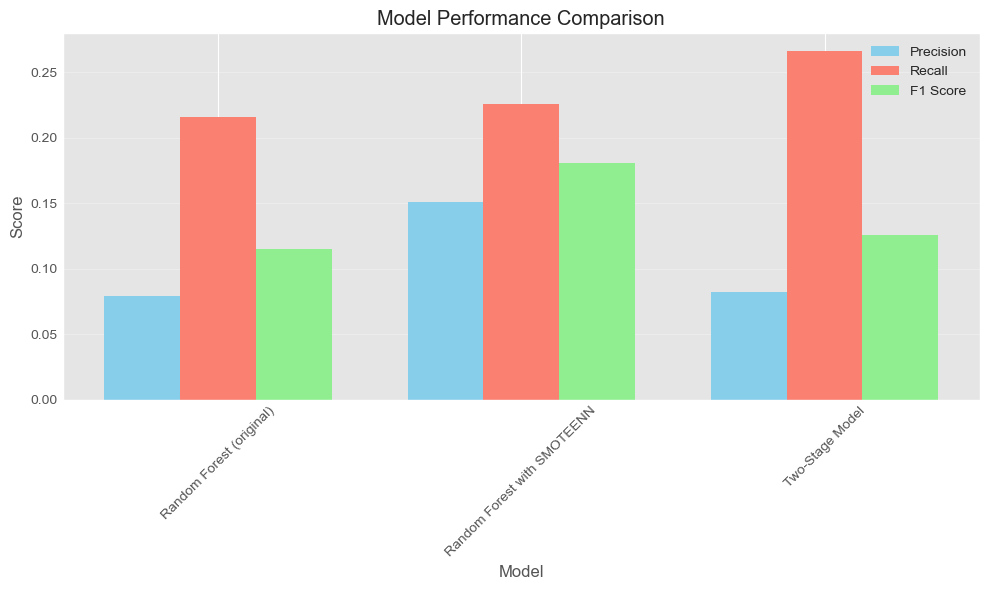


Analysis complete!


In [19]:
# ========================================
# Part 5: Two-Stage Classification Strategy for Heavy Rainfall Prediction
# ========================================

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

print("\n==== Part 5: Two-Stage Classification Strategy ====")

# ---------------
# 1. Prepare Data and Enhanced Features
# ---------------

print("\n1. Preparing data and enhanced features...")

# First ensure all necessary time features exist
if not all(col in hourly_data.columns for col in ['Hour', 'DayOfYear']):
    if isinstance(hourly_data.index, pd.DatetimeIndex):
        hourly_data['Hour'] = hourly_data.index.hour
        hourly_data['DayOfYear'] = hourly_data.index.dayofyear
    else:
        hourly_data['Hour'] = np.arange(len(hourly_data)) % 24
        hourly_data['DayOfYear'] = (np.arange(len(hourly_data)) // 24) % 365

# Create cyclical time features if they don't exist
if 'Hour_sin' not in hourly_data.columns:
    hourly_data['Hour_sin'] = np.sin(2 * np.pi * hourly_data['Hour'] / 24)
    hourly_data['Hour_cos'] = np.cos(2 * np.pi * hourly_data['Hour'] / 24)
    hourly_data['DayOfYear_sin'] = np.sin(2 * np.pi * hourly_data['DayOfYear'] / 365)
    hourly_data['DayOfYear_cos'] = np.cos(2 * np.pi * hourly_data['DayOfYear'] / 365)

# Create lagged features for key variables
for col in ['HourlyPrecipitation', 'HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure']:
    # Create 1h and 3h lags
    for lag in [1, 3]:
        col_name = f'{col}_lag_{lag}h'
        if col_name not in hourly_data.columns:
            hourly_data[col_name] = hourly_data[col].shift(lag)

# Create moving averages for key variables
for col in ['HourlyPrecipitation', 'HourlyRelativeHumidity']:
    # Create 6h and 12h moving averages
    for window in [6, 12]:
        col_name = f'{col}_avg_{window}h'
        if col_name not in hourly_data.columns:
            hourly_data[col_name] = hourly_data[col].rolling(window=window, min_periods=1).mean()

# Create temperature-humidity interaction
if 'TempHumidityIndex' not in hourly_data.columns:
    hourly_data['TempHumidityIndex'] = hourly_data['HourlyDryBulbTemperature'] * hourly_data['HourlyRelativeHumidity'] / 100

# Create dry period features if they don't exist
if 'HoursSinceLastRain' not in hourly_data.columns:
    hourly_data['HoursSinceLastRain'] = np.nan
    rainfall_events = hourly_data['HourlyPrecipitation'] > 0
    last_rain_idx = -1
    
    for idx in range(len(hourly_data)):
        if rainfall_events.iloc[idx]:
            last_rain_idx = idx
        if last_rain_idx == -1:
            hourly_data.iloc[idx, hourly_data.columns.get_loc('HoursSinceLastRain')] = idx
        else:
            hourly_data.iloc[idx, hourly_data.columns.get_loc('HoursSinceLastRain')] = idx - last_rain_idx
    
    hourly_data['LogDryPeriod'] = np.log1p(hourly_data['HoursSinceLastRain'])

# ---------------
# 2. Create Two-Stage Target Variables
# ---------------

print("\n2. Creating two-stage target variables...")

# Stage 1: Predict any rainfall (light or heavy) in the next 3 hours
# Define light rain threshold (0.01 inches/hour is considered measurable precipitation)
light_rain_threshold = 0.01

# Create binary indicators for any rainfall
hourly_data['AnyRainfall'] = (hourly_data['HourlyPrecipitation'] > light_rain_threshold).astype(int)

# Create target for any rainfall in next 3 hours
for i in range(1, 4):
    col_name = f'AnyRainfall_plus_{i}h'
    hourly_data[col_name] = hourly_data['AnyRainfall'].shift(-i)

hourly_data['AnyRainfall_Next3h'] = (
    (hourly_data['AnyRainfall_plus_1h'] == 1) | 
    (hourly_data['AnyRainfall_plus_2h'] == 1) | 
    (hourly_data['AnyRainfall_plus_3h'] == 1)
).astype(int)

# Print distribution of the new target variable
any_rain_count = hourly_data['AnyRainfall_Next3h'].sum()
any_rain_pct = any_rain_count / len(hourly_data) * 100
print(f"Any rainfall in next 3h: {any_rain_count} instances ({any_rain_pct:.2f}%)")

# Stage 2: Heavy rainfall target (already exists as HeavyRainfall_Next3h)
heavy_rain_count = hourly_data['HeavyRainfall_Next3h'].sum()
heavy_rain_pct = heavy_rain_count / len(hourly_data) * 100
print(f"Heavy rainfall in next 3h: {heavy_rain_count} instances ({heavy_rain_pct:.2f}%)")

# Also calculate conditional probability (heavy rain given any rain)
cond_prob = hourly_data[hourly_data['AnyRainfall_Next3h'] == 1]['HeavyRainfall_Next3h'].mean() * 100
print(f"Conditional probability of heavy rain given any rain: {cond_prob:.2f}%")

# ---------------
# 3. Data Splitting Strategy
# ---------------

print("\n3. Implementing data splitting strategy...")

# Make sure Week feature exists
if 'Week' not in hourly_data.columns:
    # Create a simple sequential week numbering
    hourly_data['Week'] = np.arange(len(hourly_data)) // (7 * 24)

# Get unique weeks
weeks = hourly_data['Week'].unique()
np.random.seed(42)  # For reproducibility
train_weeks = np.random.choice(weeks, size=int(0.8 * len(weeks)), replace=False)
test_weeks = np.array([week for week in weeks if week not in train_weeks])

# Create training and testing sets
train_data = hourly_data[hourly_data['Week'].isin(train_weeks)]
test_data = hourly_data[hourly_data['Week'].isin(test_weeks)]

print(f"Training set: {len(train_data)} samples, {train_data['AnyRainfall_Next3h'].mean()*100:.2f}% any rain, {train_data['HeavyRainfall_Next3h'].mean()*100:.2f}% heavy rain")
print(f"Testing set: {len(test_data)} samples, {test_data['AnyRainfall_Next3h'].mean()*100:.2f}% any rain, {test_data['HeavyRainfall_Next3h'].mean()*100:.2f}% heavy rain")

# ---------------
# 4. Define Feature Sets for Both Stages
# ---------------

print("\n4. Defining feature sets for both classification stages...")

# Basic feature set for both stages
base_features = [
    'HourlyPrecipitation', 'HourlyDryBulbTemperature', 'HourlyDewPointTemperature',
    'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyWindSpeed',
    'HourlyVisibility', 'Hour_sin', 'Hour_cos', 'DayOfYear_sin', 'DayOfYear_cos'
]

# Additional features for Stage 1 (predicting any rainfall)
rain_prediction_features = base_features + [
    'HourlyPrecipitation_lag_1h', 'HourlyPrecipitation_lag_3h',
    'HourlyRelativeHumidity_lag_1h', 'HourlyRelativeHumidity_avg_6h',
    'HourlySeaLevelPressure_lag_1h', 'LogDryPeriod'
]

# Additional features for Stage 2 (predicting heavy rainfall, given rain is predicted)
heavy_rain_prediction_features = base_features + [
    'HourlyPrecipitation_lag_1h', 'HourlyPrecipitation_lag_3h', 
    'HourlyPrecipitation_avg_6h', 'HourlyPrecipitation_avg_12h',
    'HourlyRelativeHumidity_avg_6h', 'HourlyRelativeHumidity_avg_12h',
    'HourlyDryBulbTemperature_lag_1h', 'HourlySeaLevelPressure_lag_1h',
    'TempHumidityIndex', 'LogDryPeriod'
]

# Filter to include only available features
rain_prediction_features = [f for f in rain_prediction_features if f in train_data.columns]
heavy_rain_prediction_features = [f for f in heavy_rain_prediction_features if f in train_data.columns]

print(f"Stage 1 (Any Rain): Using {len(rain_prediction_features)} features")
print(f"Stage 2 (Heavy Rain): Using {len(heavy_rain_prediction_features)} features")

# ---------------
# 5. Prepare Data for Stage 1 (Any Rainfall Prediction)
# ---------------

print("\n5. Preparing data for Stage 1 (Any Rainfall Prediction)...")

# Create feature sets for Stage 1
X_train_rain = train_data[rain_prediction_features].copy()
y_train_rain = train_data['AnyRainfall_Next3h'].copy()

X_test_rain = test_data[rain_prediction_features].copy()
y_test_rain = test_data['AnyRainfall_Next3h'].copy()

# Handle missing values
X_train_rain = X_train_rain.fillna(X_train_rain.median())
X_test_rain = X_test_rain.fillna(X_train_rain.median())  # Use training medians for test set

# Standardize features
scaler_rain = StandardScaler()
X_train_rain_scaled = scaler_rain.fit_transform(X_train_rain)
X_test_rain_scaled = scaler_rain.transform(X_test_rain)

# Balance the dataset for Stage 1 using SMOTE
# Any rainfall is more common, so we can use a moderate sampling strategy
smote_rain = SMOTE(sampling_strategy=0.5, random_state=42)  # Create 1 minority sample for every 2 majority samples
X_train_rain_resampled, y_train_rain_resampled = smote_rain.fit_resample(X_train_rain_scaled, y_train_rain)

print(f"Original Stage 1 training data: {len(X_train_rain)} samples, {y_train_rain.mean()*100:.2f}% positive class")
print(f"Resampled Stage 1 training data: {len(X_train_rain_resampled)} samples, {y_train_rain_resampled.mean()*100:.2f}% positive class")

# ---------------
# 6. Train Stage 1 Model (Any Rainfall Prediction)
# ---------------

print("\n6. Training Stage 1 Model (Any Rainfall Prediction)...")

# Stage 1: Random Forest for Any Rainfall Prediction
stage1_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

# Train the model
stage1_model.fit(X_train_rain_resampled, y_train_rain_resampled)

# Make predictions with probabilities
y_pred_rain_proba = stage1_model.predict_proba(X_test_rain_scaled)[:, 1]

# Try different thresholds for Stage 1
thresholds_stage1 = np.arange(0.2, 0.81, 0.1)
results_stage1 = []

for threshold in thresholds_stage1:
    y_pred_rain = (y_pred_rain_proba >= threshold).astype(int)
    precision = precision_score(y_test_rain, y_pred_rain)
    recall = recall_score(y_test_rain, y_pred_rain)
    f1 = f1_score(y_test_rain, y_pred_rain)
    
    results_stage1.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
    print(f"Stage 1 - Threshold {threshold:.1f}: Precision {precision:.4f}, Recall {recall:.4f}, F1 {f1:.4f}")

# Select threshold with best F1 score
best_idx = max(range(len(results_stage1)), key=lambda i: results_stage1[i]['f1'])
best_threshold_stage1 = results_stage1[best_idx]['threshold']
print(f"\nBest Stage 1 threshold: {best_threshold_stage1:.2f}")
print(f"Best F1 Score: {results_stage1[best_idx]['f1']:.4f}")

# Use best threshold for final predictions
y_pred_rain = (y_pred_rain_proba >= best_threshold_stage1).astype(int)

# Stage 1 final evaluation
conf_matrix_stage1 = confusion_matrix(y_test_rain, y_pred_rain)
print("\nStage 1 Confusion Matrix:")
print(conf_matrix_stage1)
print("\nStage 1 Classification Report:")
print(classification_report(y_test_rain, y_pred_rain))

# ---------------
# 7. Prepare Data for Stage 2 (Heavy Rainfall Prediction)
# ---------------

print("\n7. Preparing data for Stage 2 (Heavy Rainfall Prediction)...")

# In training data, filter to only cases where there is any rainfall in next 3h
rain_filter_train = train_data['AnyRainfall_Next3h'] == 1
X_train_heavy = train_data[rain_filter_train][heavy_rain_prediction_features].copy()
y_train_heavy = train_data[rain_filter_train]['HeavyRainfall_Next3h'].copy()

# For test data, we'll use predictions from Stage 1
# This simulates the real-world scenario where we first predict if it will rain
stage1_predictions = y_pred_rain == 1
X_test_heavy = test_data[stage1_predictions][heavy_rain_prediction_features].copy()
y_test_heavy = test_data[stage1_predictions]['HeavyRainfall_Next3h'].copy()

# Handle missing values
X_train_heavy = X_train_heavy.fillna(X_train_heavy.median())
X_test_heavy = X_test_heavy.fillna(X_train_heavy.median())  # Use training medians for test set

# Standardize features
scaler_heavy = StandardScaler()
X_train_heavy_scaled = scaler_heavy.fit_transform(X_train_heavy)
X_test_heavy_scaled = scaler_heavy.transform(X_test_heavy)

# Balance the dataset for Stage 2 using SMOTE
# Heavy rainfall is rare, so we need higher sampling_strategy
smote_heavy = SMOTE(sampling_strategy=1.0, random_state=42)  # Create 1 minority sample for every 1 majority sample
X_train_heavy_resampled, y_train_heavy_resampled = smote_heavy.fit_resample(X_train_heavy_scaled, y_train_heavy)

print(f"Original Stage 2 training data: {len(X_train_heavy)} samples, {y_train_heavy.mean()*100:.2f}% positive class")
print(f"Resampled Stage 2 training data: {len(X_train_heavy_resampled)} samples, {y_train_heavy_resampled.mean()*100:.2f}% positive class")
print(f"Stage 2 test data: {len(X_test_heavy)} samples, {y_test_heavy.mean()*100:.2f}% positive class")

# ---------------
# 8. Train Stage 2 Model (Heavy Rainfall Prediction)
# ---------------

print("\n8. Training Stage 2 Model (Heavy Rainfall Prediction)...")

# Stage 2: Use Gradient Boosting for Heavy Rainfall Prediction
stage2_model = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

# Train the model if we have enough data
if len(X_train_heavy_resampled) > 0 and len(X_test_heavy_scaled) > 0:
    stage2_model.fit(X_train_heavy_resampled, y_train_heavy_resampled)
    
    # Make predictions with probabilities
    y_pred_heavy_proba = stage2_model.predict_proba(X_test_heavy_scaled)[:, 1]
    
    # Try different thresholds for Stage 2
    thresholds_stage2 = np.arange(0.2, 0.81, 0.1)
    results_stage2 = []
    
    for threshold in thresholds_stage2:
        y_pred_heavy = (y_pred_heavy_proba >= threshold).astype(int)
        
        # Only calculate metrics if we have positive predictions
        if y_pred_heavy.sum() > 0:
            precision = precision_score(y_test_heavy, y_pred_heavy)
            recall = recall_score(y_test_heavy, y_pred_heavy)
            f1 = f1_score(y_test_heavy, y_pred_heavy)
            
            results_stage2.append({
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f1': f1
            })
            print(f"Stage 2 - Threshold {threshold:.1f}: Precision {precision:.4f}, Recall {recall:.4f}, F1 {f1:.4f}")
    
    # Select threshold with best F1 score
    if results_stage2:
        best_idx = max(range(len(results_stage2)), key=lambda i: results_stage2[i]['f1'])
        best_threshold_stage2 = results_stage2[best_idx]['threshold']
        print(f"\nBest Stage 2 threshold: {best_threshold_stage2:.2f}")
        print(f"Best F1 Score: {results_stage2[best_idx]['f1']:.4f}")
        
        # Use best threshold for final predictions
        y_pred_heavy = (y_pred_heavy_proba >= best_threshold_stage2).astype(int)
        
        # Stage 2 final evaluation
        conf_matrix_stage2 = confusion_matrix(y_test_heavy, y_pred_heavy)
        print("\nStage 2 Confusion Matrix:")
        print(conf_matrix_stage2)
        print("\nStage 2 Classification Report:")
        print(classification_report(y_test_heavy, y_pred_heavy))
    else:
        print("\nWarning: Could not find a threshold with positive predictions in Stage 2")
else:
    print("\nWarning: Not enough data for Stage 2 training or testing")

# ---------------
# 9. Combine Stage 1 and Stage 2 for Final Predictions
# ---------------

print("\n9. Creating final two-stage predictions...")

# Initialize final predictions (all zeros)
final_predictions = np.zeros(len(test_data))

# Get indices of samples that passed Stage 1
stage1_positive_indices = np.where(y_pred_rain == 1)[0]

# If we have Stage 2 predictions, use them for the final result
if len(X_train_heavy_resampled) > 0 and len(X_test_heavy_scaled) > 0 and len(results_stage2) > 0:
    # For those samples that passed Stage 1, apply Stage 2 predictions
    stage2_positive = y_pred_heavy == 1
    
    # Find the global indices of Stage 2 positive predictions
    # This requires mapping from Stage 2 index space back to the original test data index space
    original_indices = stage1_positive_indices[stage2_positive]
    
    # Set those positions to 1 in the final predictions
    final_predictions[original_indices] = 1

# ---------------
# 10. Evaluate Final Two-Stage Model
# ---------------

print("\n10. Evaluating final two-stage model...")

# Evaluate final predictions against original target
y_test_original = test_data['HeavyRainfall_Next3h'].values
conf_matrix_final = confusion_matrix(y_test_original, final_predictions)

print("\nFinal Two-Stage Model Confusion Matrix:")
print(conf_matrix_final)

# Calculate metrics
precision_final = precision_score(y_test_original, final_predictions)
recall_final = recall_score(y_test_original, final_predictions)
f1_final = f1_score(y_test_original, final_predictions)

print(f"\nFinal Two-Stage Model Performance:")
print(f"Precision: {precision_final:.4f}")
print(f"Recall: {recall_final:.4f}")
print(f"F1 Score: {f1_final:.4f}")
print("\nFinal Classification Report:")
print(classification_report(y_test_original, final_predictions))

# ---------------
# 11. Visualize Results and Feature Importance
# ---------------

print("\n11. Visualizing results and feature importance...")

# Create a figure for comparison
plt.figure(figsize=(12, 10))

# Plot Stage 1 confusion matrix
plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix_stage1, annot=True, fmt='d', cmap='Blues')
plt.title('Stage 1: Any Rainfall Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot Stage 2 confusion matrix if available
if 'conf_matrix_stage2' in locals():
    plt.subplot(2, 2, 2)
    sns.heatmap(conf_matrix_stage2, annot=True, fmt='d', cmap='Blues')
    plt.title('Stage 2: Heavy Rainfall Prediction')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

# Plot final confusion matrix
plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix_final, annot=True, fmt='d', cmap='Blues')
plt.title('Final Two-Stage Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot feature importance for Stage 1
plt.subplot(2, 2, 4)
if hasattr(stage1_model, 'feature_importances_'):
    importances = stage1_model.feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [rain_prediction_features[i] for i in indices])
    plt.title('Top 10 Features for Stage 1')

plt.tight_layout()
plt.show()

# If Stage 2 model was trained, plot its feature importance
if len(X_train_heavy_resampled) > 0 and hasattr(stage2_model, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    importances = stage2_model.feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [heavy_rain_prediction_features[i] for i in indices])
    plt.title('Top 10 Features for Stage 2')
    plt.tight_layout()
    plt.show()

# ---------------
# 12. Compare with Previous Approaches
# ---------------

print("\n12. Comparing with previous approaches...")

# Create a comparison table
results_comparison = pd.DataFrame({
    'Model': ['Random Forest (original)', 'Random Forest with SMOTEENN', 'Two-Stage Model'],
    'Precision': [0.0792, 0.1510, precision_final],
    'Recall': [0.2161, 0.2261, recall_final],
    'F1 Score': [0.1153, 0.1811, f1_final]
})

print("\nModel Comparison:")
print(results_comparison)

# Plot comparison
plt.figure(figsize=(10, 6))
bar_width = 0.25
x = np.arange(len(results_comparison))

plt.bar(x - bar_width, results_comparison['Precision'], width=bar_width, label='Precision', color='skyblue')
plt.bar(x, results_comparison['Recall'], width=bar_width, label='Recall', color='salmon')
plt.bar(x + bar_width, results_comparison['F1 Score'], width=bar_width, label='F1 Score', color='lightgreen')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, results_comparison['Model'], rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nAnalysis complete!")